## Dimensionality reduction and clustering

Material here is adapted in part from [this tutorial](https://github.com/marathomas/tutorial_repo) shared under CC-BY-4.0 license, that accompanied [this paper](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/1365-2656.13754).

We are using a (very tiny!) sub-set of the [Jourjine et al. 2023 dataset]() that accompanied the paper ["Two pup vocalization types are genetically and functionally separable in deer mice"](https://www.cell.com/current-biology/fulltext/S0960-9822(23)00185-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0960982223001859%3Fshowall%3Dtrue). Some code is also adapted from the [repository that reproduces the paper results](https://github.com/nickjourjine/peromyscus-pup-vocal-evolution).

In [27]:
import pathlib

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap
import hdbscan
import vocalpy as voc

## Load mouse pup call data

In [28]:
twocalls_dir = pathlib.Path("data/Jourjine-et-al-2023-two-pup-calls-subset/")
# next line, [0] because there's just one wav file
wav_path = voc.paths.from_dir(twocalls_dir / "audio", "wav")[0]

In [29]:
segs_df = pd.read_csv(twocalls_dir / "segments" / 
                      "GO_24860x23748_ltr2_pup3_ch4_4800_m_337_295_fr1_p9_2021-10-02_12-35-01.csv"
                     )

In [30]:
segs_df.head()

,start_seconds,stop_seconds,source_file,duration
0,0.526336,0.688128,/n/hoekstra_lab_tier1/Users/njourjine/manuscri...,0.161792
1,0.788480,0.919552,/n/hoekstra_lab_tier1/Users/njourjine/manuscri...,0.131072
2,1.005568,1.126400,/n/hoekstra_lab_tier1/Users/njourjine/manuscri...,0.120832
3,1.218560,1.337344,/n/hoekstra_lab_tier1/Users/njourjine/manuscri...,0.118784
4,1.435648,1.482752,/n/hoekstra_lab_tier1/Users/njourjine/manuscri...,0.047104


In [31]:
all_sounds = []
sound = voc.Sound.read(wav_path)
# ---- iterate through all the syllables in this annotation
for start_s, stop_s in zip(
    segs_df.start_seconds.values, segs_df.stop_seconds.values
):
    # ---- make a new sound with the audio data for just this syllable
    start_ind = int(start_s * sound.samplerate)
    stop_ind = int(stop_s * sound.samplerate)
    all_sounds.append(
        voc.Sound(
            data=sound.data[:, start_ind:stop_ind],
            samplerate=sound.samplerate
        )
    )

We write a function to give us back Mel spectrograms, so we can parallelize processing with VocalPy.

In [32]:
def melspectrogram(
    sound: voc.Sound, n_mels: int=50, window: str = "hann", 
    n_fft: int = 512, hop_length: int = 128, fmin=5000, fmax=125000
) -> voc.Spectrogram:
    S = librosa.feature.melspectrogram(y=sound.data,
                                       sr=sound.samplerate, 
                                       n_mels=n_mels , 
                                       fmax=fmax, 
                                       fmin=fmin,
                                       n_fft=n_fft,
                                       hop_length=hop_length, 
                                       window=window, 
                                       win_length=n_fft)
    S = librosa.power_to_db(S, ref=np.max)
    t = librosa.frames_to_time(frames=np.arange(S.shape[-1]), sr=sound.samplerate, hop_length=hop_length)
    f = librosa.mel_frequencies(n_mels=n_mels, fmin=fmin, fmax=fmax)
    return voc.Spectrogram(data=S[0, ...], frequencies=f, times=t)

In [33]:
callback = melspectrogram

spect_maker = voc.SpectrogramMaker(callback)

In [34]:
all_spects = spect_maker.make(all_sounds, parallelize=True)

[########################################] | 100% Completed | 2.71 sms


Now we get the numpy arrays directly, and we throw away the channel dimension.

In [35]:
all_spects = [
    spect.data[0, ...]
    for spect in all_spects
]

This should give us a two-dimensional array, with dimensions (frequency, time)

In [36]:
all_spects[0].shape

(50, 317)

Let's visualize a random subset, just to inspect our data.

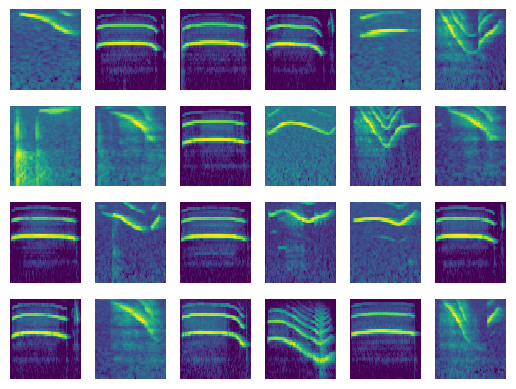

In [37]:
import random

fig, ax_arr = plt.subplots(4, 6)
ax_arr = ax_arr.ravel()
for ax, spect in zip(ax_arr, random.sample(all_spects, len(all_spects))):
    ax.pcolormesh(spect)
    ax.set_axis_off()

Now we need to know the maximum number of time bins in any of the spectrograms, so we can pad all the spectrograms to the same size.

In [38]:
max_width = np.max([
    spect.data.shape[1] for spect in all_spects   
])

We also use the minimum value to pad, so we don't add some very large value in the padding, that could impact the UMAP calculation.

In [39]:
min_val = np.min([spect.min() for spect in all_spects])

In [40]:
def pad_spect(spect, max_width=max_width, constant_values=min_val):
    pad_width = max_width - spect.shape[1]
    # pad with half the width needed on both sides
    left_pad = pad_width // 2
    right_pad = pad_width - left_pad
    return np.pad(
        spect, ((0, 0), (left_pad, right_pad)), mode='constant', constant_values=min_val,
    )

In [41]:
all_spects = [
    pad_spect(spect, max_width)
    for spect in all_spects
]

Let's make sure that worked

In [42]:
all(
    [spect.shape[1] == max_width for spect in all_spects]
)

True

Again we visualize a random sample just to double check things are working as expected.

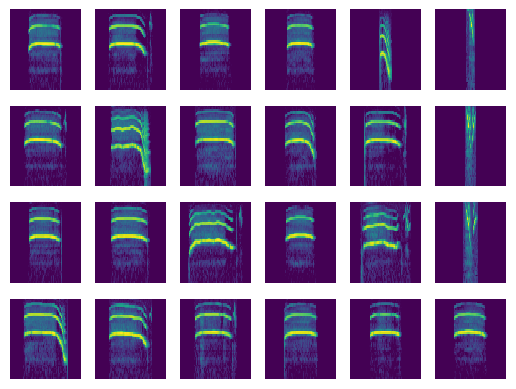

In [43]:
import random

fig, ax_arr = plt.subplots(4, 6)
ax_arr = ax_arr.ravel()
for ax, spect in zip(ax_arr, random.sample(all_spects, len(all_spects))):
    ax.pcolormesh(spect)
    ax.set_axis_off()

In [44]:
data = np.array([
    spect.flatten() for spect in all_spects
])

## Dimensionality reduction with UMAP

In [45]:
reducer = umap.UMAP(
    n_components=2, min_dist=0.25, n_neighbors=15, verbose=True
)

In [46]:
embedding = reducer.fit_transform(data)

UMAP(min_dist=0.25, verbose=True)
Sun May 19 14:44:11 2024 Construct fuzzy simplicial set
Sun May 19 14:44:17 2024 Finding Nearest Neighbors
Sun May 19 14:44:17 2024 Finished Nearest Neighbor Search
Sun May 19 14:44:17 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun May 19 14:44:19 2024 Finished embedding


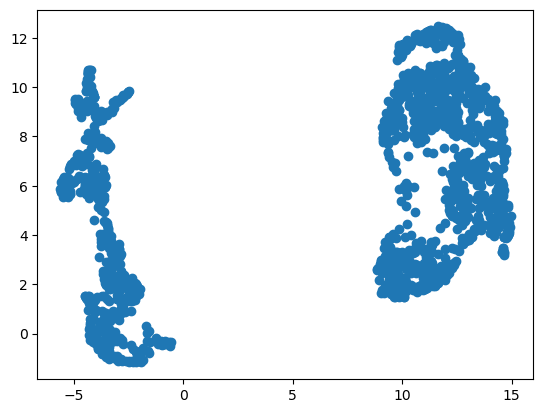

In [47]:
plt.scatter(embedding[:, 0], embedding[:, 1])

## Clustering with HDBSCAN

In [48]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, allow_single_cluster=True)

In [49]:
clusterer.fit(embedding)

HDBSCAN(allow_single_cluster=True, min_cluster_size=100)

We plot using the "labels", that is, the integer class representing the cluster that each data point has been assigned to.

In [50]:
y = clusterer.labels_
import matplotlib as mpl
cmap = mpl.colormaps['tab20'].resampled(np.unique(y).shape[0])
c = cmap.colors[y]

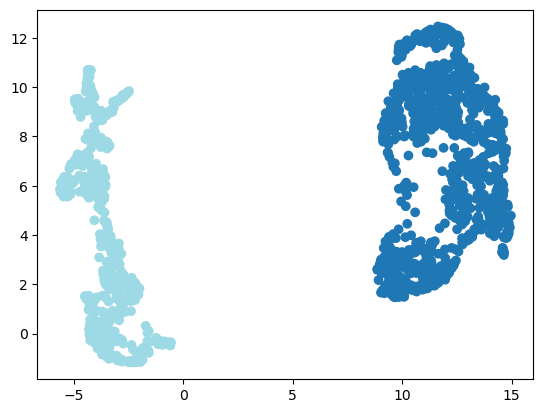

In [51]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=c);